<a href="https://colab.research.google.com/github/Brymer-Meneses/Plant-Doctor/blob/main/machine_learning/apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites


In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

import os 
import shutil

from zipfile import ZipFile
from os.path import join
from os import listdir
from google.colab import drive

import math 
import random 

In [2]:
drive.mount('drive', force_remount=True)

Mounted at drive


# File Structuring

In [3]:
!wget https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded

--2021-02-20 13:26:57--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/d29ed9b2-8a5d-4663-8a82-c9174f2c7066 [following]
--2021-02-20 13:26:57--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/d29ed9b2-8a5d-4663-8a82-c9174f2c7066
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.37.136
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.37.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 868032562 (828M) [applicati

In [4]:
os.rename('file_downloaded', "plantvillage_ds.zip")
with ZipFile('plantvillage_ds.zip', 'r') as file:
  file.extractall()

os.remove('plantvillage_ds.zip')
os.rename('/content/Plant_leave_diseases_dataset_without_augmentation', "/content/dataset")

In [5]:
# Plants to be deleted 
def delete_plants(dataset_plant):
  dataset_dir = "/content/dataset"
  for plant in os.listdir(dataset_dir):
    if not dataset_plant in plant.lower():
      shutil.rmtree(join(dataset_dir, plant))
  return

In [6]:
def train_val_test_split(source_dir, destination_dir, data_split=[0.6, 0.2, 0.2]):

  """Copies the file structure of a directory and splits it for 
  train, test, validation.

  source_dir/
    ├─ folder1/
    ├─ folder2/
    ├─ .../

  destination_dir/
    |
    ├─ train/
    │   ├─ folder1/
    │   ├─ folder2/
    │   ├─ .../
    │
    ├─ test/
    │   ├─ folder1/
    │   ├─ folder2/
    │   ├─ .../
    |
    ├─ val/
    │   ├─ folder1/
    │   ├─ folder2/
    │   ├─ .../

  
  """
  assert float(data_split[0] + data_split[1] + data_split[2]) == 1.0, "Data Split must be equal to 1"
  if not os.path.isdir(destination_dir):
    os.mkdir(destination_dir)
  
  dirs = ["train", "val", "test"]

  for dir in dirs:
    try:
      os.mkdir(os.path.join(destination_dir, dir))
    except Exception as e:
      print(e)

    for plant_type in os.listdir(source_dir):
      try:
        os.mkdir(os.path.join(destination_dir, dir, plant_type))
      except Exception as e:
        print(e)

  
  def split(source, destination, total):
    counter = 0
    while not counter == total:
      random_image = random.choice(os.listdir(source))
      image_source = os.path.join(source, random_image)
     
      image_destination = os.path.join(destination, random_image)

      shutil.move(image_source, image_destination)

      counter += 1
    return

  for folder in os.listdir(source_dir):
    
  
    total_images = len(os.listdir(os.path.join(source_dir, folder)))
    train_total = math.floor(total_images * data_split[0])
    test_total = math.floor(total_images * data_split[1])
    val_total = math.floor(total_images * data_split[2])

    split(join(source_dir, folder), os.path.join(destination_dir, "train", folder), train_total)
    split(join(source_dir, folder), os.path.join(destination_dir, "test", folder), test_total)
    split(join(source_dir, folder), os.path.join(destination_dir, "val", folder), val_total)

    print(f"Successfully splitted data from {os.path.join(source_dir, folder)} {os.path.join(destination_dir, folder)}")
    print(f"\t - Train Images: {train_total}")
    print(f"\t - Val Images: {val_total}")
    print(f"\t - Test Images: {train_total}")
    
  return 






# Model Training

In [7]:
delete_plants("apple")


In [8]:
train_val_test_split("/content/dataset", "/content/split")

Successfully splitted data from /content/dataset/Apple___Apple_scab /content/split/Apple___Apple_scab
	 - Train Images: 378
	 - Val Images: 126
	 - Test Images: 378
Successfully splitted data from /content/dataset/Apple___Cedar_apple_rust /content/split/Apple___Cedar_apple_rust
	 - Train Images: 165
	 - Val Images: 55
	 - Test Images: 165
Successfully splitted data from /content/dataset/Apple___healthy /content/split/Apple___healthy
	 - Train Images: 987
	 - Val Images: 329
	 - Test Images: 987
Successfully splitted data from /content/dataset/Apple___Black_rot /content/split/Apple___Black_rot
	 - Train Images: 372
	 - Val Images: 124
	 - Test Images: 372


In [9]:
from tensorflow.keras.models import load_model, save_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
# We will fine-tune EfficientLite-Lite4
img_size = 380
batch_size = 64

train_dir = "/content/split/train"
val_dir = "/content/split/val"
test_dir = "/content/split/test"

In [17]:
# Data Split
# Training Data - 60%
# Validation Data - 20%
# Test Data - 20%

datagen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = [0.7, 1.3],
    zoom_range = [0.9, 1.1],
    rescale = 1/255,
)

train_gen = datagen.flow_from_directory(
    train_dir, 
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True,
)

test_gen = datagen.flow_from_directory(
    test_dir, 
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = False,
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True,
)


Found 1902 images belonging to 4 classes.
Found 634 images belonging to 4 classes.
Found 634 images belonging to 4 classes.


In [18]:
URL = 'https://tfhub.dev/tensorflow/efficientnet/lite4/feature-vector/2'
pretrained_model = hub.KerasLayer(URL, input_shape = (img_size, img_size,3))

In [25]:
apple_model = Sequential(name="Apple_Model")
apple_model.add(Flatten())
apple_model.add(Dense(512, activation = 'relu'))
apple_model.add(Dropout(.30))
apple_model.add(Dense(len(train_gen.class_indices), activation = 'softmax'))

training_model = Sequential([
                             pretrained_model, 
                             apple_model,
])

In [26]:
training_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              11837936  
_________________________________________________________________
Apple_Model (Sequential)     (None, 4)                 657924    
Total params: 12,495,860
Trainable params: 657,924
Non-trainable params: 11,837,936
_________________________________________________________________


In [27]:
training_model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=['accuracy'])
es = EarlyStopping(monitor = 'val_loss', patience =3)

In [28]:
training_history = training_model.fit(train_gen, validation_data= val_gen, epochs = 5, callbacks = es)

Epoch 1/5
30/30 [==============================] - 90s 3s/step - loss: 0.8083 - accuracy: 0.6763 - val_loss: 0.2699 - val_accuracy: 0.8927
Epoch 2/5
30/30 [==============================] - 86s 3s/step - loss: 0.2135 - accuracy: 0.9207 - val_loss: 0.1690 - val_accuracy: 0.9353
Epoch 3/5
30/30 [==============================] - 86s 3s/step - loss: 0.1233 - accuracy: 0.9616 - val_loss: 0.1534 - val_accuracy: 0.9543
Epoch 4/5
30/30 [==============================] - 86s 3s/step - loss: 0.1053 - accuracy: 0.9599 - val_loss: 0.0896 - val_accuracy: 0.9669
Epoch 5/5
30/30 [==============================] - 86s 3s/step - loss: 0.0937 - accuracy: 0.9723 - val_loss: 0.0931 - val_accuracy: 0.9685


In [29]:
os.chdir("/content/drive/MyDrive/Research/models")
apple_model.save("apple.h5")

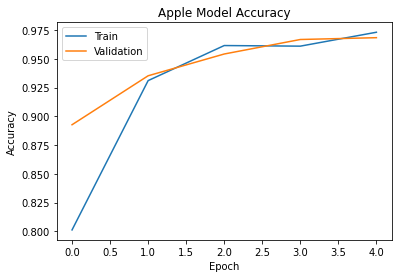

In [31]:
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Apple Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.show()
